# Question 1 (2 Marks)
Download the fashion-MNIST dataset and plot 1 sample image for each class as shown in the grid below. Use ```from keras.datasets import fashion_mnist``` for getting the fashion mnist dataset.

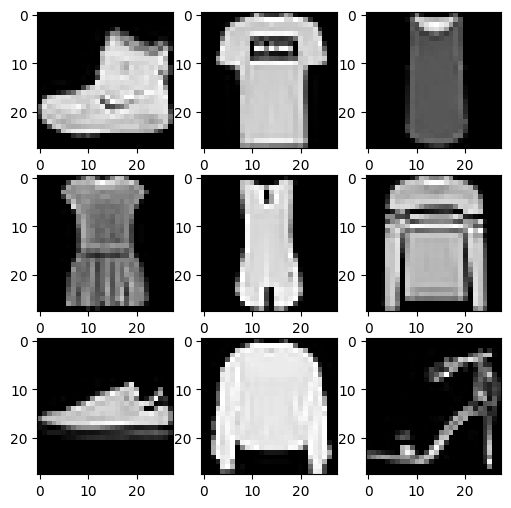

In [ ]:
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt

(xTrain, yTrain), (xTest, yTest) = fashion_mnist.load_data()

no_class = 9

plt.figure(figsize=(6,6))  
for i in range(no_class):
    plt.subplot(3, 3, i+1)
    plt.imshow(xTrain[i], cmap="gray")  
plt.show()


Question 2 (10 Marks)

Implement a feedforward neural network which takes images from the fashion-mnist data as input and outputs a probability distribution over the 10 classes.

Your code should be flexible such that it is easy to change the number of hidden layers and the number of neurons in each hidden layer.

In [ ]:
import numpy as np
import pandas as pd

from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt

(xTrain, yTrain), (xTest, yTest) = fashion_mnist.load_data()

X = xTrain.T
Y = yTrain

num_class = 10

#number of neurons per hidden layer and number of hidden layers
no_neurons = 50
no_hiddenLayers = 7


def sigmoid(x):
    return 1/(1+np.exp(-x))

def neuron(input, w, b, activation):
    z = np.dot(input, w)+b
    return activation(z)

def hiddenLayer(input, w, b, activation):
    output = np.dot(input, w)+b
    return activation(output)



def softmax(x):
    exp = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp/np.sum(exp, axis=1, keepdims=True)

class feed_for_nn:
    def __init__(self, input_size, hidden_layers, output_size):
        self.layers = [input_size] + hidden_layers + [output_size]  
        self.weights = [np.random.randn(self.layers[i], self.layers[i+1]) * 0.01 for i in range(len(self.layers) - 1)]
        self.biases = [np.zeros((1, self.layers[i+1])) for i in range(len(self.layers) - 1)]
    

    def forward_pass(self, X):
        self.a = [X]

        for i in range (len(self.weights)):
            if i == len(self.weights) - 1:
                activation = softmax
            else:
                activation = sigmoid
            layer_op = hiddenLayer(self.a[-1], self.weights[i], self.biases[i], activation)
            self.a.append(layer_op)
        return self.a[-1]
    
  
xTest = xTest.reshape(xTest.shape[0], -1)/255.0

hidden_layers = []

for i in range(no_hiddenLayers):
    neurons = no_neurons
    hidden_layers.append(neurons)


model = feed_for_nn(784, hidden_layers, num_class)

output_probs = model.forward_pass(xTest)

num_test_images = int(input(f"number of images to get the probability distribution: "))

print(output_probs[:5])



[[0.09571975 0.09464313 0.10169632 0.09838201 0.09901309 0.09613947
  0.10219179 0.10548554 0.10496211 0.1017668 ]
 [0.09571975 0.09464313 0.10169632 0.09838201 0.09901309 0.09613947
  0.10219179 0.10548554 0.10496211 0.1017668 ]
 [0.09571975 0.09464313 0.10169632 0.09838201 0.09901309 0.09613947
  0.10219179 0.10548554 0.10496211 0.1017668 ]
 [0.09571975 0.09464313 0.10169632 0.09838201 0.09901309 0.09613947
  0.10219179 0.10548554 0.10496211 0.1017668 ]
 [0.09571975 0.09464313 0.10169632 0.09838201 0.09901309 0.09613947
  0.10219179 0.10548554 0.10496211 0.1017668 ]]
